In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.networks import ScoreNet
from sdebridge.utils import plot_2d_vector_field, plot_2d_trajectories, plot_trajectories, eval_score

plt.style.use('ggplot')

## 2 Dimensional

### Learn the transition density of $X_t$

In [3]:
d = 2

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.array([[1.0, 0.0], [0.0, 1.0]]),     
    dim=d,
    end_time=1.0,
    num_steps=50,
    true_score_transition=lambda x, x0, t: -(x - x0) / t,
    true_score_h=lambda x, xT, t, T: -(x - xT) / (T - t),
)

(32, 51, 2)


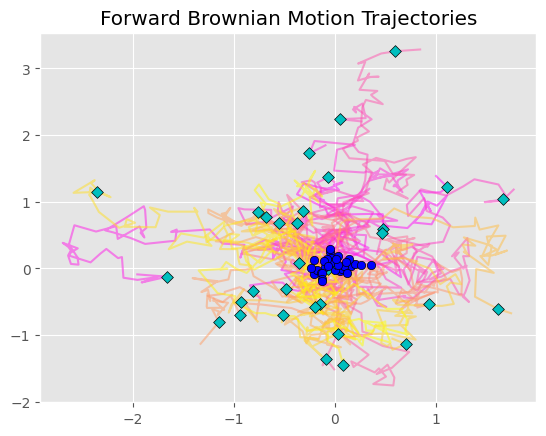

In [4]:
forward_brownian_motion_trajectories = model.simulate_forward_process(initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)))
print(forward_brownian_motion_trajectories.shape)
plot_2d_trajectories(forward_brownian_motion_trajectories, title="Forward Brownian Motion Trajectories")

In [5]:
train_params = {"batch_size": 32, "num_epochs": 20, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=128,
                                embedding_dim=128,
                                act='leaky_relu',
                                encoder_layer_dims=[128, 128],
                                decoder_layer_dims=[128, 128],
                                using_batchnorm=False)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=jnp.array([0.0, 0.0]), 
                                                              training_params=train_params)

Epoch 1 / 20: loss = 45.7028
Epoch 2 / 20: loss = 44.8923
Epoch 3 / 20: loss = 45.0420
Epoch 4 / 20: loss = 44.8563
Epoch 5 / 20: loss = 44.9159
Epoch 6 / 20: loss = 44.9694
Epoch 7 / 20: loss = 44.5787
Epoch 8 / 20: loss = 44.9582
Epoch 9 / 20: loss = 45.0131
Epoch 10 / 20: loss = 44.9212
Epoch 11 / 20: loss = 44.5475
Epoch 12 / 20: loss = 44.9530
Epoch 13 / 20: loss = 44.6236
Epoch 14 / 20: loss = 44.8867
Epoch 15 / 20: loss = 44.6927
Epoch 16 / 20: loss = 44.8814
Epoch 17 / 20: loss = 44.8914
Epoch 18 / 20: loss = 44.7606
Epoch 19 / 20: loss = 44.8369
Epoch 20 / 20: loss = 44.6830


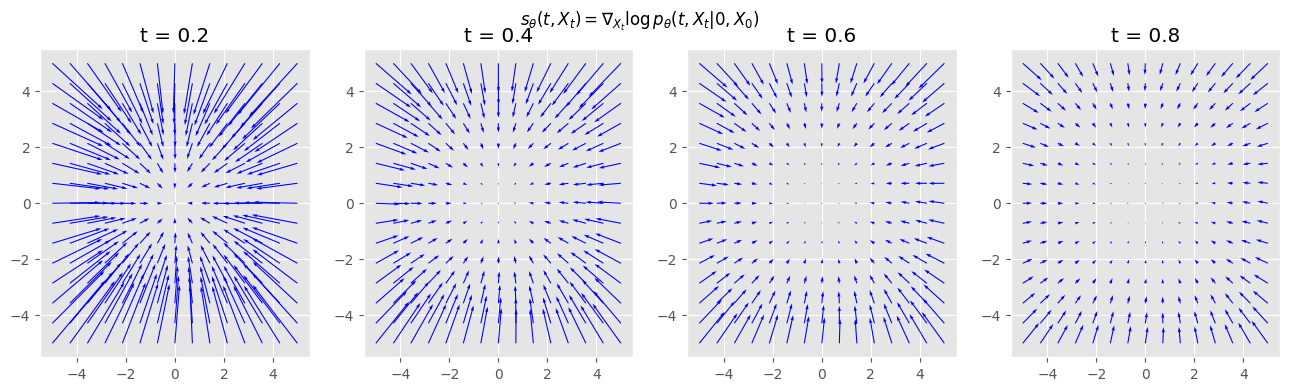

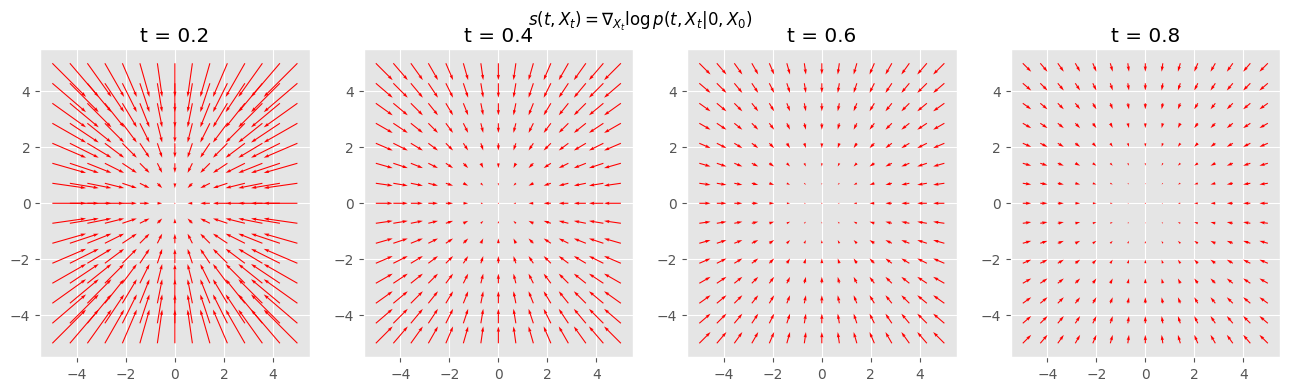

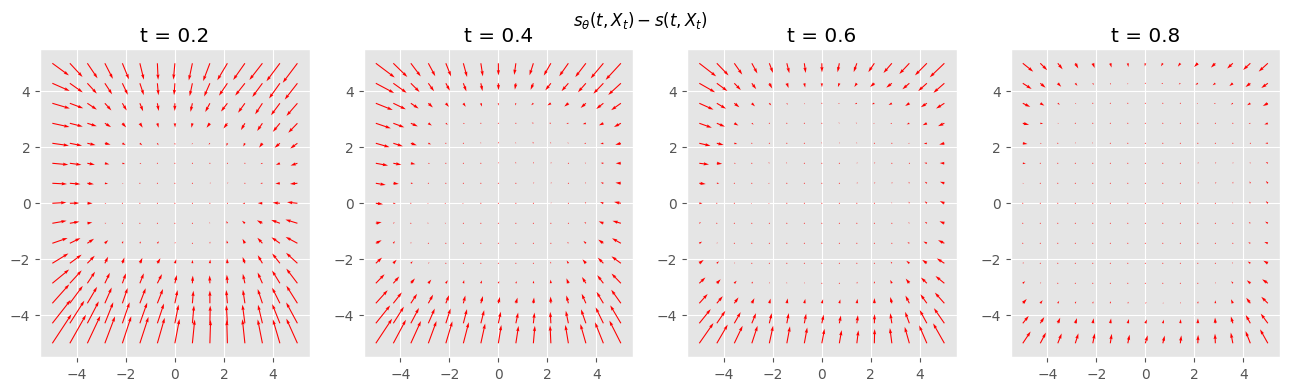

In [21]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_transition_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: -(x-x0)/t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: eval_score(score_transition_state, x, t) - (-(x-x0)/t),
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

### Use learned transition score to simulate the backward bridge

(32, 51, 2)


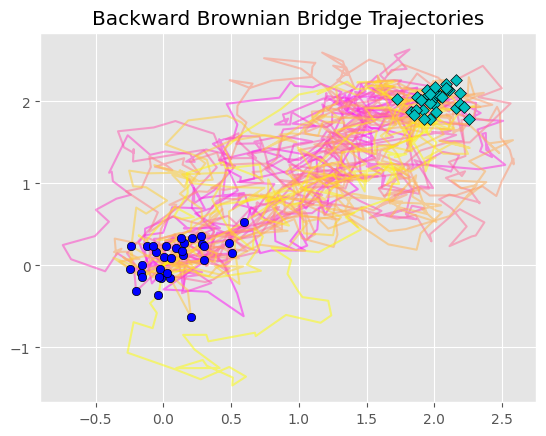

In [14]:
backward_brownian_bridge_trajectories = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                                       initial_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                       terminal_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                       using_true_score=False)
print(backward_brownian_bridge_trajectories.shape)
plot_2d_trajectories(backward_brownian_bridge_trajectories, title="Backward Brownian Bridge Trajectories")

### Exam the intermediate stage distribution

For a Brownian bridge $(X^*_t)$, $p^*(t, X^*_t)$ is the transition density, which can be written as:
$$ p^*(t, x_t) = \frac{p(t, x_t|0, x_0)p(T, x_T|t, x_t)}{p(T, x_T|0, x_0)} $$
Take the score for the both sides w.r.t $x_t$:
$$ \nabla_{x_t}\log p^*(t, x_t) = \nabla_{x_t}\log p(t, x_t|0, x_0) + \nabla_{x_t} \log p(T, x_T|t, x_t) - \nabla_{x_t} \log p(T, x_T|0, x_0) $$
Considering all the $p$s have Gaussian closed forms:
$$ p(t, x_t|0, x_0) = C_1\exp(-\frac{\|x_t-x_0\|^2}{2t}) $$
$$ p(T, x_T|t, x_t) = C_2\exp(-\frac{\|x_T-x_t\|^2}{2(T-t)}) $$
$$ p(T, x_T|0, x_0) = C_3\exp(-\frac{\|x_T-x_0\|^2}{2T}) $$
The score of the transition density of the Brownian bridge is:
$$ s^*(t, x_t) = \nabla_{x_t} \log p^*(t, x_t) = \frac{x_T-x_t}{T-t} - \frac{x_t-x_0}{t} $$

In [15]:
# Covariance calculations
def product_gaussian(sigma1, sigma2):
    """ Covariance of N(mu1, sigma1^2) * N(mu2, sigma2^2)
    """
    sigma = (sigma1**2 * sigma2**2) / (sigma1**2 + sigma2**2)
    return sigma

def quotient_gaussian(sigma1, sigma2):
    """ Covariance of N(mu1, sigma1^2) / N(mu2, sigma2^2)
    """
    sigma = (sigma1**2 * sigma2**2) / (sigma1**2 - sigma2**2)
    return sigma

def forward_browian_bridge_transition(t, T):
    sigma1 = t
    sigma2 = T - t
    sigma3 = T
    sigma0 = product_gaussian(sigma1, sigma2)
    sigma = quotient_gaussian(sigma0, sigma3)
    return sigma

In [16]:
num_trajectories = 4096
XT = jnp.tile(jnp.array([[2.0, 2.0]]), reps=(num_trajectories, 1))
X0 = jnp.tile(jnp.array([[0.0, 0.0]]), reps=(num_trajectories, 1))
backward_brownian_bridge_trajectories = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                                       initial_condition=XT, 
                                                                       terminal_condition=X0, 
                                                                       using_true_score=True)
print(backward_brownian_bridge_trajectories.shape)

(4096, 51, 2)


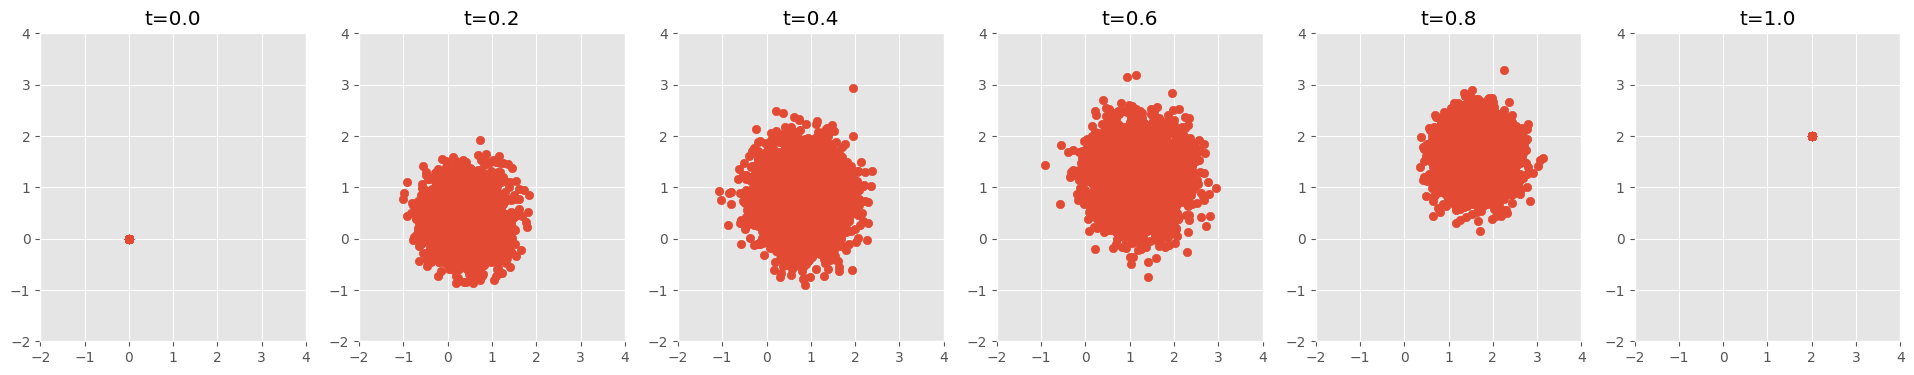

In [17]:
fig, ax = plt.subplots(1, 6, figsize=(24, 4))
for i in range(5+1):
    ax[i].scatter(backward_brownian_bridge_trajectories[:, i*10, 0], backward_brownian_bridge_trajectories[:, i*10, 1])
    ax[i].set_title(f"t={model.ts[i*10]:.1f}")
    ax[i].set_xlim([-2.0, 4.0])
    ax[i].set_ylim([-2.0, 4.0])

Text(0, 0.5, 'MSE')

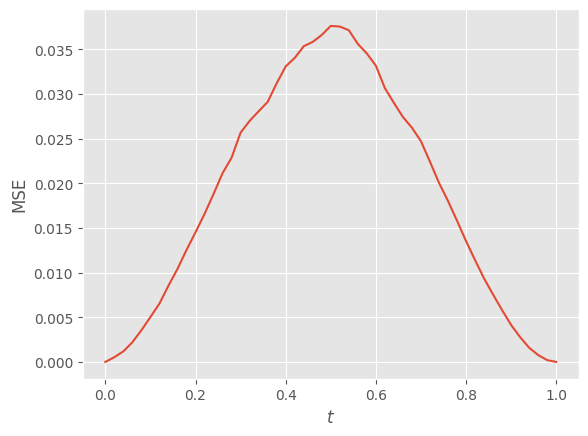

In [19]:
true_variances = jax.vmap(forward_browian_bridge_transition, in_axes=(0, None))(model.ts, model.T)
backward_brownian_bridge_covariance = jax.vmap(lambda x: jnp.cov(x, rowvar=False), in_axes=1)(backward_brownian_bridge_trajectories)
errors = jax.vmap(lambda x, var: jnp.mean(jnp.square(x - jnp.eye(2)*var)), in_axes=(0, 0))(backward_brownian_bridge_covariance, true_variances)
plt.plot(model.ts, errors)
plt.xlabel(r"$t$")
plt.ylabel("MSE")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [20]:
train_params = {"batch_size": 32, "num_epochs": 20, "num_batches_per_epoch": 20, "learning_rate": 1e-3}
score_marginal_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=128,
                                embedding_dim=128,
                                act='tanh',
                                encoder_layer_dims=[128, 128],
                                decoder_layer_dims=[128, 128],
                                using_batchnorm=False)
score_marginal_state = model.learn_marginal_score(score_marginal_net=score_marginal_net,
                                                   initial_condition=jnp.array([2.0, 2.0]),
                                                   terminal_condition=jnp.array([0.0, 0.0]),
                                                   score_transition_state=score_transition_state,
                                                   training_params=train_params)

Epoch 1 / 20: loss = 53.9145
Epoch 2 / 20: loss = 52.1944
Epoch 3 / 20: loss = 51.4021
Epoch 4 / 20: loss = 51.7665
Epoch 5 / 20: loss = 50.9167
Epoch 6 / 20: loss = 50.9128
Epoch 7 / 20: loss = 50.3570
Epoch 8 / 20: loss = 50.7086
Epoch 9 / 20: loss = 50.7040
Epoch 10 / 20: loss = 50.7592
Epoch 11 / 20: loss = 50.4847
Epoch 12 / 20: loss = 50.1165
Epoch 13 / 20: loss = 50.5210
Epoch 14 / 20: loss = 50.2909
Epoch 15 / 20: loss = 49.9239
Epoch 16 / 20: loss = 49.9061
Epoch 17 / 20: loss = 50.2064
Epoch 18 / 20: loss = 50.0682
Epoch 19 / 20: loss = 50.5603
Epoch 20 / 20: loss = 49.6234


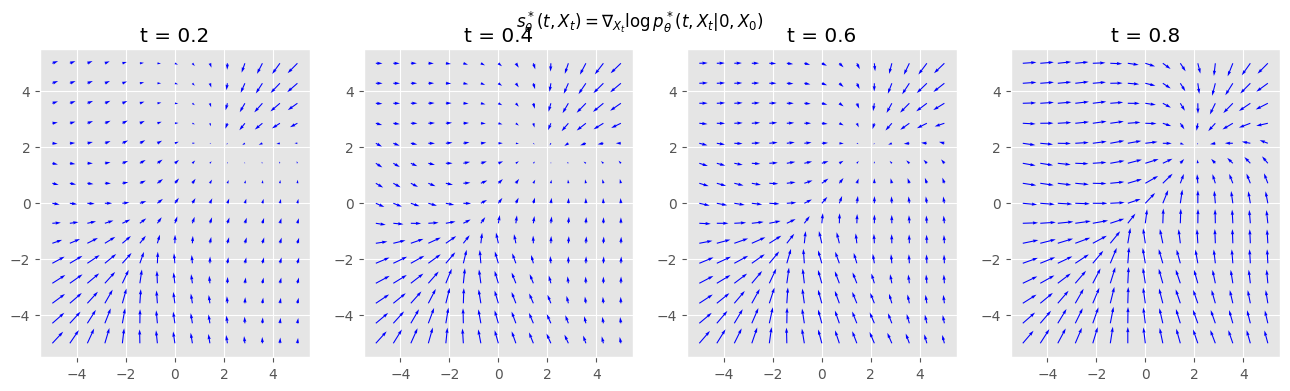

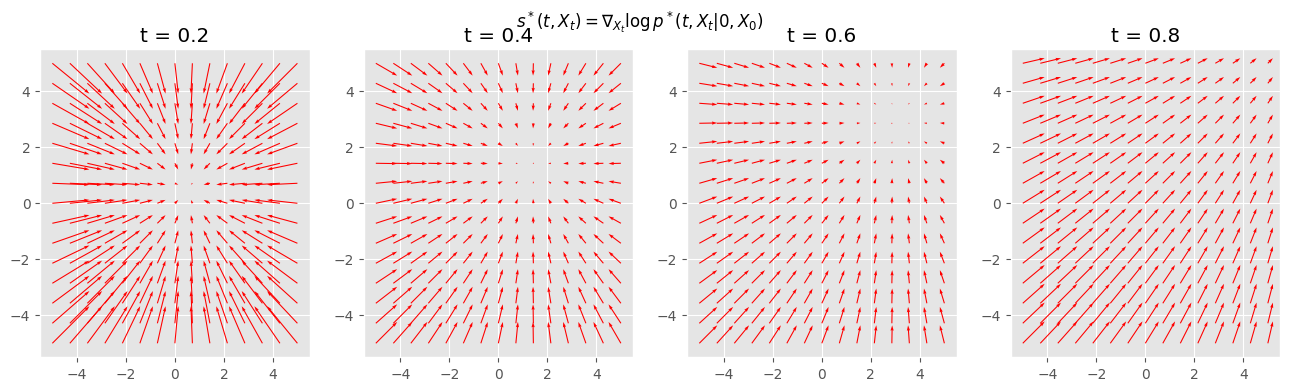

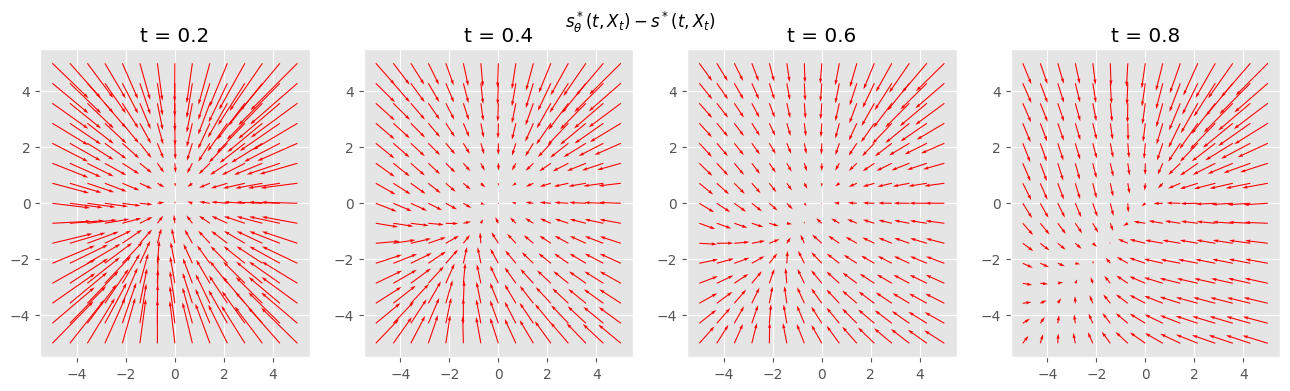

In [23]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_marginal_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t)=\nabla_{X_t}\log p^*_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*(t, X_t)=\nabla_{X_t}\log p^*(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 2.0]),
                     T=1.0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: eval_score(score_marginal_state, x, t) - (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t) - s^*(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 2.0]),
                     T=1.0)

(32, 51, 2)


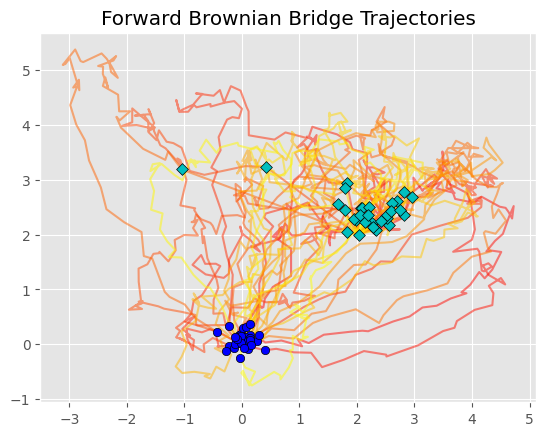

In [58]:
forward_brownian_bridge_trajectories = model.simulate_forward_bridge(score_transition_state=score_transition_state, 
                                                                     score_marginal_state=score_marginal_state,
                                                                     initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                     terminal_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                     using_true_score=False)
print(forward_brownian_bridge_trajectories.shape)
plot_2d_trajectories(forward_brownian_bridge_trajectories, title="Forward Brownian Bridge Trajectories")

### Higher dimension

In [62]:
d = 16

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.eye(d),
    dim=d,
    end_time=1.0,
    num_steps=100,
    true_score_transition=None,
    true_score_h=None,
)

In [76]:
def sample_circle(num_points: int) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, num_points, endpoint=False)
    x = jnp.cos(theta)
    y = jnp.sin(theta)
    return jnp.stack([x, y], axis=1).flatten()

def sample_square(num_points: int) -> jnp.ndarray:
    shift = 2.0 * jnp.ones(2*num_points)
    num_points_per_side = num_points // 4
    x1 = jnp.linspace(-1, 1, num_points_per_side, endpoint=False)
    x2 = jnp.linspace(1, -1, num_points_per_side, endpoint=False)
    y1 = jnp.linspace(-1, 1, num_points_per_side, endpoint=False)
    y2 = jnp.linspace(1, -1, num_points_per_side, endpoint=False)
    xy1 = jnp.stack([x1, jnp.ones_like(x1)], axis=1)
    xy2 = jnp.stack([jnp.ones_like(y1), y2], axis=1)
    xy3 = jnp.stack([x2, -jnp.ones_like(x2)], axis=1)
    xy4 = jnp.stack([-jnp.ones_like(y1), y1], axis=1)
    return jnp.concatenate([xy1, xy2, xy3, xy4], axis=0).flatten() + shift

(16,) (16,)


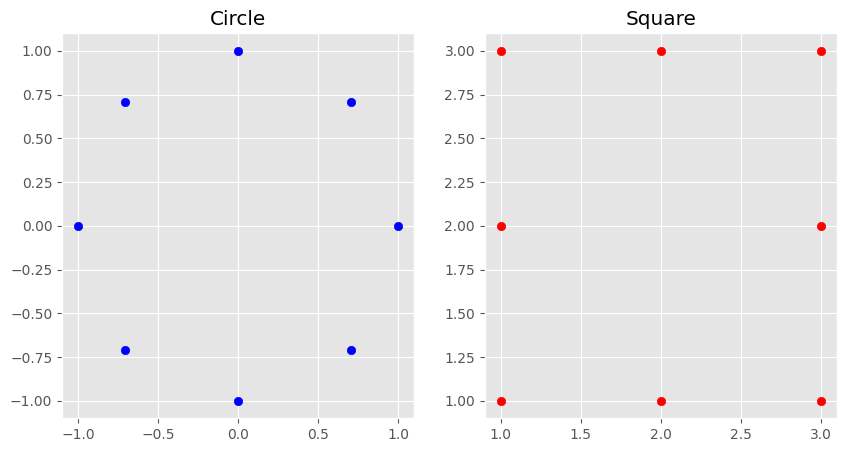

In [77]:
circles = sample_circle(num_points=d//2)
squares = sample_square(num_points=d//2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(circles.reshape(-1, 2)[:, 0], circles.reshape(-1, 2)[:, 1], color='b')
ax[0].set_title("Circle")
ax[1].scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
ax[1].set_title("Square")
print(circles.shape, squares.shape)

(5, 101, 16)


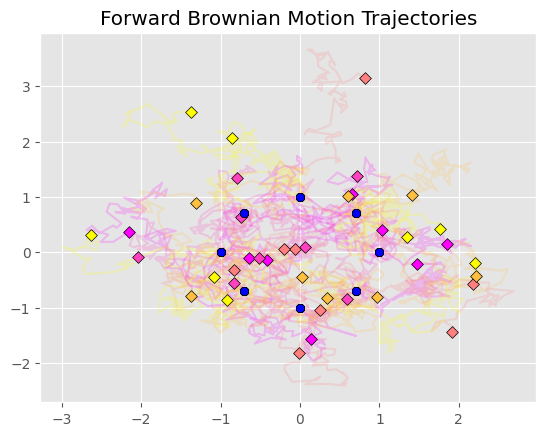

In [78]:
initial_condition = sample_circle(num_points=d//2)
forward_brownian_motion_trajectories = model.simulate_forward_process(initial_condition=jnp.tile(initial_condition, reps=(5, 1)))
print(forward_brownian_motion_trajectories.shape)
plot_trajectories(forward_brownian_motion_trajectories, title="Forward Brownian Motion Trajectories")

In [79]:
train_params = {"batch_size": 64, "num_epochs": 50, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=128,
                                embedding_dim=128,
                                act='leaky_relu',
                                encoder_layer_dims=[128, 128],
                                decoder_layer_dims=[128, 128],
                                using_batchnorm=False)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=initial_condition, 
                                                              training_params=train_params)

Epoch 1 / 50: loss = 96.8312
Epoch 2 / 50: loss = 95.0290
Epoch 3 / 50: loss = 94.5698
Epoch 4 / 50: loss = 94.4098
Epoch 5 / 50: loss = 94.3504
Epoch 6 / 50: loss = 94.2257
Epoch 7 / 50: loss = 94.4734
Epoch 8 / 50: loss = 94.3612
Epoch 9 / 50: loss = 94.2009
Epoch 10 / 50: loss = 94.2901
Epoch 11 / 50: loss = 94.2310
Epoch 12 / 50: loss = 94.1981
Epoch 13 / 50: loss = 94.2544
Epoch 14 / 50: loss = 94.2844
Epoch 15 / 50: loss = 94.1633
Epoch 16 / 50: loss = 94.2490
Epoch 17 / 50: loss = 94.2461
Epoch 18 / 50: loss = 94.1880
Epoch 19 / 50: loss = 94.2240
Epoch 20 / 50: loss = 94.1933
Epoch 21 / 50: loss = 94.1346
Epoch 22 / 50: loss = 94.1902
Epoch 23 / 50: loss = 94.1883
Epoch 24 / 50: loss = 94.2023
Epoch 25 / 50: loss = 94.2028
Epoch 26 / 50: loss = 94.1231
Epoch 27 / 50: loss = 94.1362
Epoch 28 / 50: loss = 94.0558
Epoch 29 / 50: loss = 94.1475
Epoch 30 / 50: loss = 94.0750
Epoch 31 / 50: loss = 94.1662
Epoch 32 / 50: loss = 94.1243
Epoch 33 / 50: loss = 94.2021
Epoch 34 / 50: loss

(1, 101, 16)


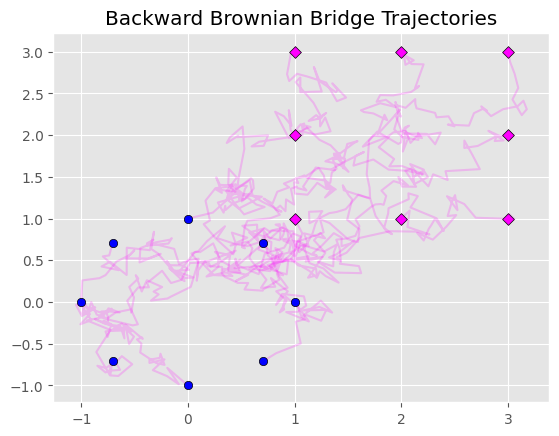

In [83]:
initial_shape = sample_circle(num_points=d//2)
terminal_shape = sample_square(num_points=d//2)

backward_brownian_bridge_trajectories = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                                       initial_condition=jnp.tile(terminal_shape, reps=(1, 1)), 
                                                                       terminal_condition=jnp.tile(initial_shape, reps=(1, 1)), 
                                                                       using_true_score=False)
print(backward_brownian_bridge_trajectories.shape)
plot_trajectories(backward_brownian_bridge_trajectories, title="Backward Brownian Bridge Trajectories")